In [262]:
import numpy as np
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import time
from tensorflow.keras.datasets import mnist
from sklearn.metrics import precision_score, recall_score



In [263]:
# Helper function
def show_images(image, num_row=2, num_col=5):
    # plot images
    image_size = int(np.sqrt(image.shape[-1]))
    image = np.reshape(image, (image.shape[0], image_size, image_size))
    fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
    for i in range(num_row*num_col):
        ax = axes[i//num_col, i%num_col]
        ax.imshow(image[i], cmap='gray', vmin=0, vmax=1)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
def one_hot(x, k, dtype=np.float32):
    """Create a one-hot encoding of x of size k."""
    return np.array(x[:, None] == np.arange(k), dtype)

**Dataset preparation**

In [265]:
# MNIST veri setini yükle
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize et ve veriyi hazırlık yap
x_train = x_train / 255.0
x_test = x_test / 255.0
x_train = x_train.reshape(60000, 28 * 28)
x_test = x_test.reshape(10000, 28 * 28)

# One-hot encoding
def one_hot(y, num_classes):
    return np.eye(num_classes)[y]

num_labels = 10
y_train = one_hot(y_train, num_labels)
y_test = one_hot(y_test, num_labels)


Training data: (60000, 784) (60000, 10)
Test data: (10000, 784) (10000, 10)


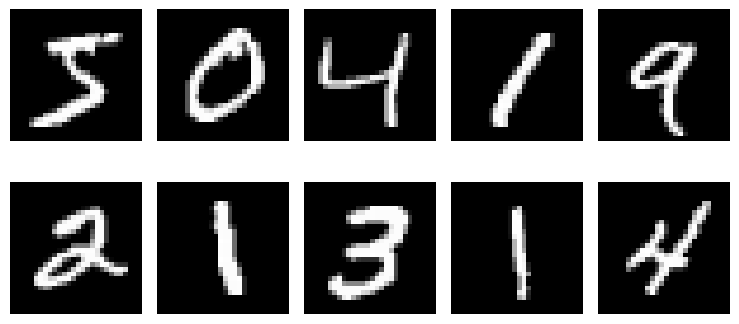

In [266]:
print("Training data: {} {}".format(x_train.shape, y_train.shape))
print("Test data: {} {}".format(x_test.shape, y_test.shape))
show_images(x_train)

### Initialization

In [268]:
class DeepNeuralNetwork():
    def __init__(self, sizes, activation='sigmoid', optimizer='sgd'):
        self.sizes = sizes
        self.optimizer = optimizer
        if activation == 'relu':
            self.activation = self.relu
        elif activation == 'sigmoid':
            self.activation = self.sigmoid
        else:
            raise ValueError("Supported activation functions are 'relu' and 'sigmoid'.")
        self.params = self.initialize()
        self.momentum_opt = {key: np.zeros_like(value) for key, value in self.params.items()}
        self.adam_opt = {key: np.zeros_like(value) for key, value in self.params.items()}
        
    def relu(self, x, derivative=False):
        if derivative:
            return (x > 0).astype(float)
        return np.maximum(0, x)

    def sigmoid(self, x, derivative=False):
        sig = 1 / (1 + np.exp(-x))
        if derivative:
            return sig * (1 - sig)
        return sig

    def softmax(self, x):
        exps = np.exp(x - np.max(x, axis=0, keepdims=True))
        return exps / np.sum(exps, axis=0, keepdims=True)

    def initialize(self):
        input_layer = self.sizes[0]
        hidden_layer = self.sizes[1]
        output_layer = self.sizes[2]
        return {
            "W1": np.random.randn(hidden_layer, input_layer) * np.sqrt(1. / input_layer),
            "b1": np.zeros((hidden_layer, 1)),
            "W2": np.random.randn(output_layer, hidden_layer) * np.sqrt(1. / hidden_layer),
            "b2": np.zeros((output_layer, 1))
        }

    def feed_forward(self, x):
        self.cache = {}
        self.cache["X"] = x
        self.cache["Z1"] = np.matmul(self.params["W1"], self.cache["X"].T) + self.params["b1"]
        self.cache["A1"] = self.activation(self.cache["Z1"])
        self.cache["Z2"] = np.matmul(self.params["W2"], self.cache["A1"]) + self.params["b2"]
        self.cache["A2"] = self.softmax(self.cache["Z2"])
        return self.cache["A2"]

    def back_propagate(self, y, output, lambda_=0, regularization=None):
        current_batch_size = y.shape[0]
        dZ2 = output - y.T
        dW2 = (1. / current_batch_size) * np.matmul(dZ2, self.cache["A1"].T)
        db2 = (1. / current_batch_size) * np.sum(dZ2, axis=1, keepdims=True)
        dA1 = np.matmul(self.params["W2"].T, dZ2)
        dZ1 = dA1 * self.activation(self.cache["Z1"], derivative=True)
        dW1 = (1. / current_batch_size) * np.matmul(dZ1, self.cache["X"])
        db1 = (1. / current_batch_size) * np.sum(dZ1, axis=1, keepdims=True)
        if regularization == "L2":
            dW2 += (lambda_ / current_batch_size) * self.params["W2"]
            dW1 += (lambda_ / current_batch_size) * self.params["W1"]
        elif regularization == "L1":
            dW2 += (lambda_ / current_batch_size) * np.sign(self.params["W2"])
            dW1 += (lambda_ / current_batch_size) * np.sign(self.params["W1"])
        self.grads = {"W1": dW1, "b1": db1, "W2": dW2, "b2": db2}

    def optimize(self, l_rate=0.01, beta=0.9, beta2=0.999, epsilon=1e-8):
        if self.optimizer == "sgd":
            for key in self.params:
                self.params[key] -= l_rate * self.grads[key]
    
        elif self.optimizer == "momentum":
            for key in self.params:
                self.momentum_opt[key] = (beta * self.momentum_opt[key] + (1 - beta) * self.grads[key])
                self.params[key] -= l_rate * self.momentum_opt[key]
    
        elif self.optimizer == "adam":
            if not hasattr(self, 'adam_m'):
                self.adam_m = {key: np.zeros_like(value) for key, value in self.params.items()}
                self.adam_v = {key: np.zeros_like(value) for key, value in self.params.items()}
                self.t = 0
    
            self.t += 1
            for key in self.params:
                self.adam_m[key] = beta * self.adam_m[key] + (1 - beta) * self.grads[key]
                self.adam_v[key] = beta2 * self.adam_v[key] + (1 - beta2) * (self.grads[key] ** 2)
    
                m_hat = self.adam_m[key] / (1 - beta ** self.t)
                v_hat = self.adam_v[key] / (1 - beta2 ** self.t)
    
                self.params[key] -= l_rate * m_hat / (np.sqrt(v_hat) + epsilon)
    
        elif self.optimizer == "rmsprop":
            if not hasattr(self, 'rmsprop_cache'):
                self.rmsprop_cache = {key: np.zeros_like(value) for key, value in self.params.items()}
    
            for key in self.params:
                self.rmsprop_cache[key] = beta * self.rmsprop_cache[key] + (1 - beta) * (self.grads[key] ** 2)
                self.params[key] -= l_rate * self.grads[key] / (np.sqrt(self.rmsprop_cache[key]) + epsilon)
    
        else:
            raise ValueError(f"Unsupported optimizer: {self.optimizer}")

    def cross_entropy_loss(self, y, output, lambda_=0, regularization=None):
        m = y.shape[0]
        loss = -np.sum(y * np.log(output.T)) / m
        if regularization == "L2":
            l2_term = (lambda_ / (2 * m)) * (np.sum(np.square(self.params["W1"])) + np.sum(np.square(self.params["W2"])))
            loss += l2_term
        elif regularization == "L1":
            l1_term = (lambda_ / m) * (np.sum(np.abs(self.params["W1"])) + np.sum(np.abs(self.params["W2"])))
            loss += l1_term
        return loss

    def accuracy(self, y, output):
        predictions = np.argmax(output, axis=0)
        labels = np.argmax(y, axis=1)
        return np.mean(predictions == labels)

    def precision_recall(self, y_true, y_pred):
        y_true = np.argmax(y_true, axis=1)
        y_pred = np.argmax(y_pred, axis=0)
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        return precision, recall

    def train(self, x_train, y_train, x_test, y_test, epochs=10, batch_size=64, l_rate=0.01, lambda_=0, regularization=None):
        train_acc_list, test_acc_list = [], []
        train_loss_list, test_loss_list = [], []
        train_precision_list, test_precision_list = [], []
        train_recall_list, test_recall_list = [], []
    
        for epoch in range(epochs):
            permutation = np.random.permutation(x_train.shape[0])
            x_train_shuffled = x_train[permutation]
            y_train_shuffled = y_train[permutation]
            num_batches = x_train.shape[0] // batch_size
    
            for batch_idx in range(num_batches):
                start = batch_idx * batch_size
                end = start + batch_size
                x_batch = x_train_shuffled[start:end]
                y_batch = y_train_shuffled[start:end]
    
                output = self.feed_forward(x_batch)
                self.back_propagate(y_batch, output, lambda_, regularization)
                self.optimize(l_rate=l_rate)
    
            train_output = self.feed_forward(x_train)
            test_output = self.feed_forward(x_test)
    
            train_loss = self.cross_entropy_loss(y_train, train_output, lambda_, regularization)
            test_loss = self.cross_entropy_loss(y_test, test_output, lambda_, regularization)
    
            train_acc = self.accuracy(y_train, train_output)
            test_acc = self.accuracy(y_test, test_output)
    
            train_precision, train_recall = self.precision_recall(y_train, train_output)
            test_precision, test_recall = self.precision_recall(y_test, test_output)
    
            train_loss_list.append(train_loss)
            test_loss_list.append(test_loss)
            train_acc_list.append(train_acc)
            test_acc_list.append(test_acc)
            train_precision_list.append(train_precision)
            test_precision_list.append(test_precision)
            train_recall_list.append(train_recall)
            test_recall_list.append(test_recall)
    
            print(f"Epoch {epoch + 1}/{epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}")
    
        # Sonuçları döndür
        return (train_acc_list, test_acc_list, train_loss_list, test_loss_list, 
                train_precision_list, test_precision_list, train_recall_list, test_recall_list)


### Optimizer Sonuçlarının Karşılaştırılması

In [270]:
optimizers = ['sgd', 'momentum', 'adam', 'rmsprop']
results = {}

for opt in optimizers:
    print(f"\nTraining with optimizer: {opt}")
    # Modeli başlat, optimizer'ı burada geçiriyoruz
    model = DeepNeuralNetwork(sizes=[784, 128, 10], activation='relu', optimizer=opt)
    
    # Zaman ölçümünü başlat
    start_time = time.time()
    
    # Modeli eğit
    train_acc_list, test_acc_list, train_loss_list, test_loss_list, train_precision_list, test_precision_list, train_recall_list, test_recall_list = model.train(
        x_train=x_train,
        y_train=y_train,
        x_test=x_test,
        y_test=y_test,
        epochs=10,
        batch_size=64,
        l_rate=0.01
    )
    
    # Zaman ölçümünü bitir
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    # Sonuçları kaydet
    results[opt] = {
        "train_acc": train_acc_list,
        "test_acc": test_acc_list,
        "train_loss": train_loss_list,
        "test_loss": test_loss_list,
        "train_precision": train_precision_list,
        "test_precision": test_precision_list,
        "train_recall": train_recall_list,
        "test_recall": test_recall_list,
        "time": elapsed_time
    }

# Sonuçları Yazdırma
print("\nComparison Results")
print("-" * 120)
print(f"{'Optimizer':<12} {'Train Acc':<12} {'Test Acc':<12} {'Train Loss':<12} {'Test Loss':<12} {'Train Prec':<12} {'Test Prec':<12} {'Train Recall':<12} {'Test Recall':<12} {'Time (s)':<10}")
print("-" * 120)
for opt in optimizers:
    train_acc = results[opt]['train_acc'][-1]  # Son epoch'daki eğitim doğruluğu
    test_acc = results[opt]['test_acc'][-1]   # Son epoch'daki test doğruluğu
    train_loss = results[opt]['train_loss'][-1]  # Son epoch'daki eğitim kaybı
    test_loss = results[opt]['test_loss'][-1]    # Son epoch'daki test kaybı
    train_precision = results[opt]['train_precision'][-1]  # Son epoch'daki eğitim precision
    test_precision = results[opt]['test_precision'][-1]    # Son epoch'daki test precision
    train_recall = results[opt]['train_recall'][-1]  # Son epoch'daki eğitim recall
    test_recall = results[opt]['test_recall'][-1]    # Son epoch'daki test recall
    elapsed_time = results[opt]['time']       # Eğitim süresi
    print(f"{opt:<12} {train_acc:<12.4f} {test_acc:<12.4f} {train_loss:<12.4f} {test_loss:<12.4f} {train_precision:<12.4f} {test_precision:<12.4f} {train_recall:<12.4f} {test_recall:<12.4f} {elapsed_time:<10.2f}")
print("-" * 120)



Training with optimizer: sgd
Epoch 1/10 - Train Loss: 0.5300, Train Acc: 0.8705, Precision: 0.8699, Recall: 0.8705
Epoch 2/10 - Train Loss: 0.3970, Train Acc: 0.8925, Precision: 0.8924, Recall: 0.8925
Epoch 3/10 - Train Loss: 0.3487, Train Acc: 0.9027, Precision: 0.9025, Recall: 0.9027
Epoch 4/10 - Train Loss: 0.3209, Train Acc: 0.9099, Precision: 0.9097, Recall: 0.9099
Epoch 5/10 - Train Loss: 0.3000, Train Acc: 0.9156, Precision: 0.9156, Recall: 0.9156
Epoch 6/10 - Train Loss: 0.2837, Train Acc: 0.9206, Precision: 0.9205, Recall: 0.9206
Epoch 7/10 - Train Loss: 0.2700, Train Acc: 0.9248, Precision: 0.9246, Recall: 0.9248
Epoch 8/10 - Train Loss: 0.2582, Train Acc: 0.9273, Precision: 0.9272, Recall: 0.9273
Epoch 9/10 - Train Loss: 0.2472, Train Acc: 0.9306, Precision: 0.9306, Recall: 0.9306
Epoch 10/10 - Train Loss: 0.2376, Train Acc: 0.9335, Precision: 0.9335, Recall: 0.9335

Training with optimizer: momentum
Epoch 1/10 - Train Loss: 0.5306, Train Acc: 0.8683, Precision: 0.8678, Rec

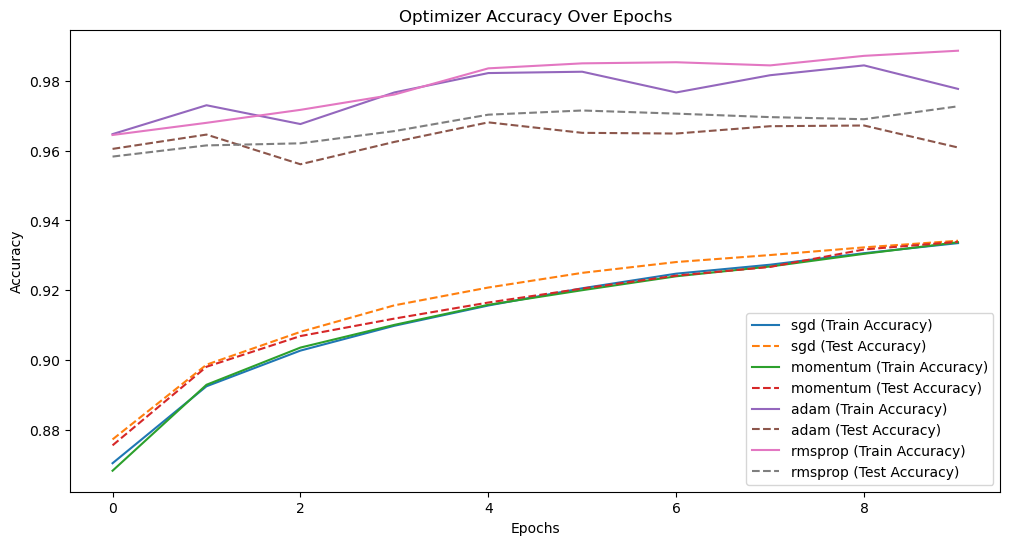

In [271]:
# Accuracy grafiği
plt.figure(figsize=(12, 6))
for opt in optimizers:
    plt.plot(results[opt]['train_acc'], label=f"{opt} (Train Accuracy)")
    plt.plot(results[opt]['test_acc'], linestyle='--', label=f"{opt} (Test Accuracy)")

plt.title("Optimizer Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


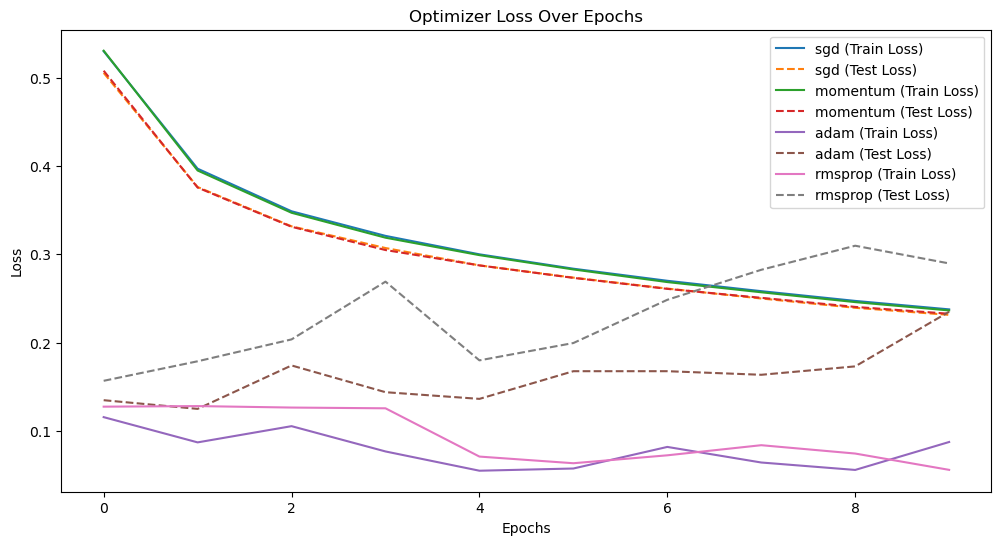

In [272]:
# Loss Grafiği
plt.figure(figsize=(12, 6))
for opt in optimizers:
    plt.plot(results[opt]['train_loss'], label=f"{opt} (Train Loss)")
    plt.plot(results[opt]['test_loss'], linestyle='--', label=f"{opt} (Test Loss)")

plt.title("Optimizer Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


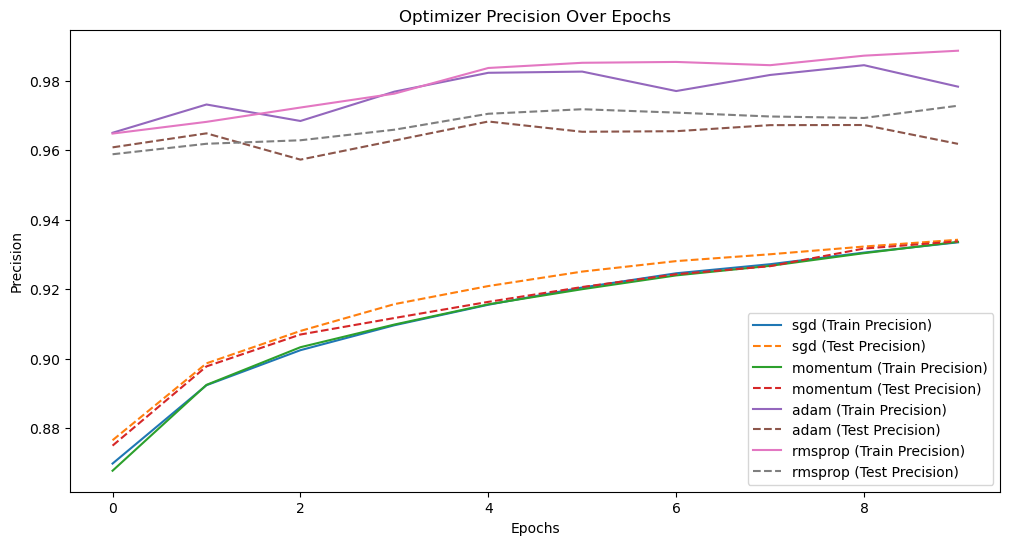

In [273]:
# Precision Grafiği
plt.figure(figsize=(12, 6))
for opt in optimizers:
    plt.plot(results[opt]['train_precision'], label=f"{opt} (Train Precision)")
    plt.plot(results[opt]['test_precision'], linestyle='--', label=f"{opt} (Test Precision)")

plt.title("Optimizer Precision Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.legend()
plt.show()


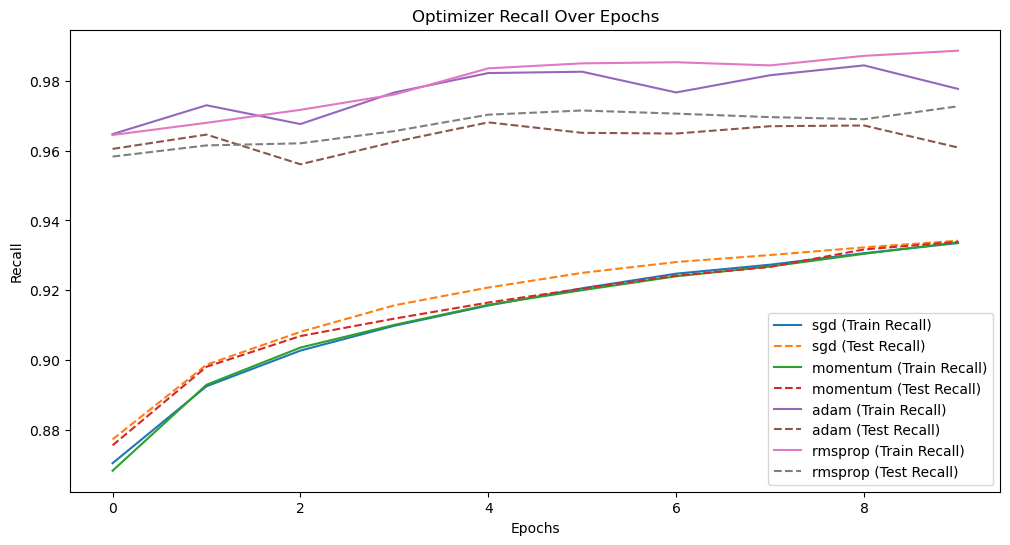

In [274]:
# Recall Grafiği
plt.figure(figsize=(12, 6))
for opt in optimizers:
    plt.plot(results[opt]['train_recall'], label=f"{opt} (Train Recall)")
    plt.plot(results[opt]['test_recall'], linestyle='--', label=f"{opt} (Test Recall)")

plt.title("Optimizer Recall Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.legend()
plt.show()


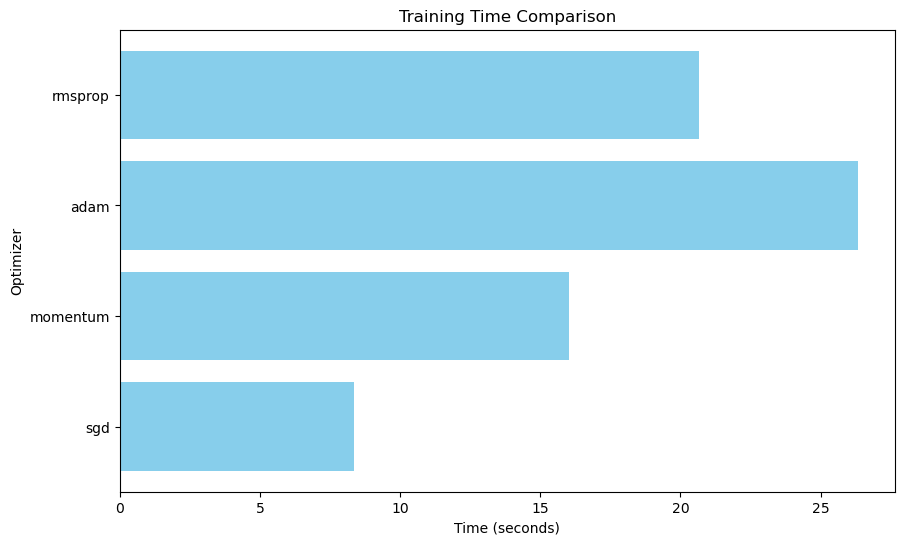

In [275]:
# Training Time Grafiği
plt.figure(figsize=(10, 6))
time_labels = list(results.keys())
time_values = [results[opt]['time'] for opt in optimizers]

plt.barh(time_labels, time_values, color='skyblue')
plt.title("Training Time Comparison")
plt.xlabel("Time (seconds)")
plt.ylabel("Optimizer")
plt.show()


### Regularization Sonuçlarının Karşılaştırılması

In [277]:
results = {}
regularizations = [None, "L1", "L2"]
optimizers = ['sgd', 'momentum', 'adam', 'rmsprop']

for reg in regularizations:
    results[reg] = {}
    for opt in optimizers:
        print(f"\nTraining with optimizer: {opt} and regularization: {reg}")
        model = DeepNeuralNetwork([784, 128, 10], activation='relu', optimizer=opt)
        
        # Zaman ölçümünü başlat
        start_time = time.time()
        
        # Modeli eğit ve metrikleri al
        train_acc, test_acc, train_loss, test_loss, train_precision, test_precision, train_recall, test_recall = model.train(
            x_train=x_train,
            y_train=y_train,
            x_test=x_test,
            y_test=y_test,
            epochs=10,
            batch_size=64,
            l_rate=0.01,
            lambda_=0.01,
            regularization=reg
        )
        
        # Zaman ölçümünü bitir
        end_time = time.time()
        elapsed_time = end_time - start_time
        
        # Sonuçları kaydet
        results[reg][opt] = {
            "train_acc": train_acc,
            "test_acc": test_acc,
            "train_loss": train_loss,
            "test_loss": test_loss,
            "train_precision": train_precision,
            "test_precision": test_precision,
            "train_recall": train_recall,
            "test_recall": test_recall,
            "time": elapsed_time
        }

# Sonuçları Yazdırma
print("\nComparison Results")
print("-" * 120)
print(f"{'Regularization':<15} {'Optimizer':<12} {'Train Acc':<12} {'Test Acc':<12} {'Train Loss':<12} {'Test Loss':<12} {'Train Prec':<12} {'Test Prec':<12} {'Train Recall':<12} {'Test Recall':<12} {'Time (s)':<10}")
print("-" * 120)
for reg in regularizations:
    for opt in optimizers:
        train_acc = results[reg][opt]['train_acc'][-1]  # Son epoch'daki eğitim doğruluğu
        test_acc = results[reg][opt]['test_acc'][-1]   # Son epoch'daki test doğruluğu
        train_loss = results[reg][opt]['train_loss'][-1]  # Son epoch'daki eğitim kaybı
        test_loss = results[reg][opt]['test_loss'][-1]    # Son epoch'daki test kaybı
        train_precision = results[reg][opt]['train_precision'][-1]  # Son epoch'daki eğitim precision
        test_precision = results[reg][opt]['test_precision'][-1]    # Son epoch'daki test precision
        train_recall = results[reg][opt]['train_recall'][-1]  # Son epoch'daki eğitim recall
        test_recall = results[reg][opt]['test_recall'][-1]    # Son epoch'daki test recall
        elapsed_time = results[reg][opt]['time']       # Eğitim süresi
        print(f"{reg or 'No Regularization':<15} {opt:<12} {train_acc:<12.4f} {test_acc:<12.4f} {train_loss:<12.4f} {test_loss:<12.4f} {train_precision:<12.4f} {test_precision:<12.4f} {train_recall:<12.4f} {test_recall:<12.4f} {elapsed_time:<10.2f}")
print("-" * 120)



Training with optimizer: sgd and regularization: None
Epoch 1/10 - Train Loss: 0.5288, Train Acc: 0.8694, Precision: 0.8687, Recall: 0.8694
Epoch 2/10 - Train Loss: 0.3968, Train Acc: 0.8914, Precision: 0.8909, Recall: 0.8914
Epoch 3/10 - Train Loss: 0.3498, Train Acc: 0.9036, Precision: 0.9034, Recall: 0.9036
Epoch 4/10 - Train Loss: 0.3220, Train Acc: 0.9101, Precision: 0.9098, Recall: 0.9101
Epoch 5/10 - Train Loss: 0.3029, Train Acc: 0.9144, Precision: 0.9141, Recall: 0.9144
Epoch 6/10 - Train Loss: 0.2869, Train Acc: 0.9198, Precision: 0.9197, Recall: 0.9198
Epoch 7/10 - Train Loss: 0.2730, Train Acc: 0.9236, Precision: 0.9234, Recall: 0.9236
Epoch 8/10 - Train Loss: 0.2609, Train Acc: 0.9271, Precision: 0.9269, Recall: 0.9271
Epoch 9/10 - Train Loss: 0.2498, Train Acc: 0.9300, Precision: 0.9300, Recall: 0.9300
Epoch 10/10 - Train Loss: 0.2399, Train Acc: 0.9328, Precision: 0.9328, Recall: 0.9328

Training with optimizer: momentum and regularization: None
Epoch 1/10 - Train Loss:

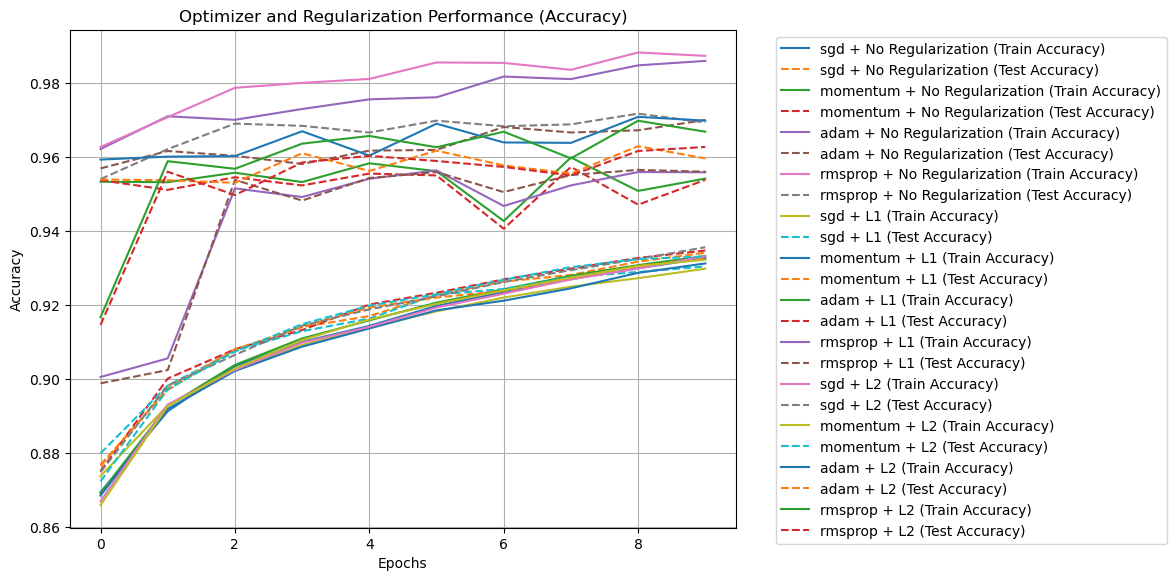

In [278]:
plt.figure(figsize=(12, 6))

# Her regularization ve optimizer kombinasyonu için çizim
for reg in regularizations:
    for opt in optimizers:
        # Train Accuracy
        if 'train_acc' in results[reg][opt] and len(results[reg][opt]['train_acc']) > 0:
            plt.plot(results[reg][opt]['train_acc'], label=f"{opt} + {reg or 'No Regularization'} (Train Accuracy)")
        # Test Accuracy
        if 'test_acc' in results[reg][opt] and len(results[reg][opt]['test_acc']) > 0:
            plt.plot(results[reg][opt]['test_acc'], linestyle='--', label=f"{opt} + {reg or 'No Regularization'} (Test Accuracy)")

plt.title("Optimizer and Regularization Performance (Accuracy)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()


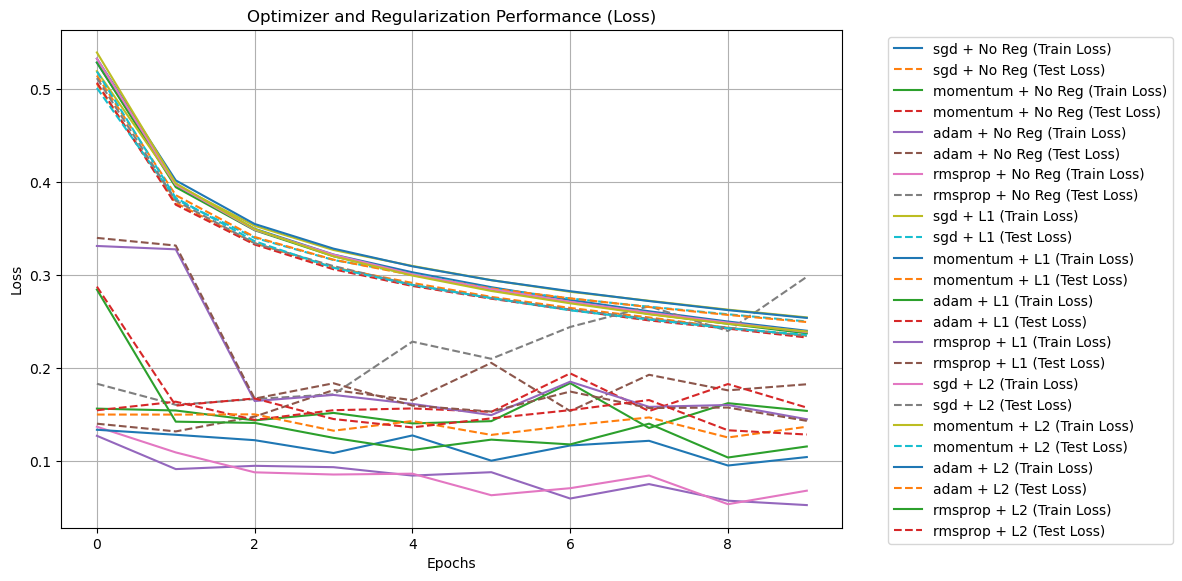

In [279]:
# Loss Grafiği
plt.figure(figsize=(12, 6))
for reg in regularizations:
    for opt in optimizers:
        plt.plot(results[reg][opt]['train_loss'], label=f"{opt} + {reg or 'No Reg'} (Train Loss)")
        plt.plot(results[reg][opt]['test_loss'], linestyle='--', label=f"{opt} + {reg or 'No Reg'} (Test Loss)")

plt.title("Optimizer and Regularization Performance (Loss)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()


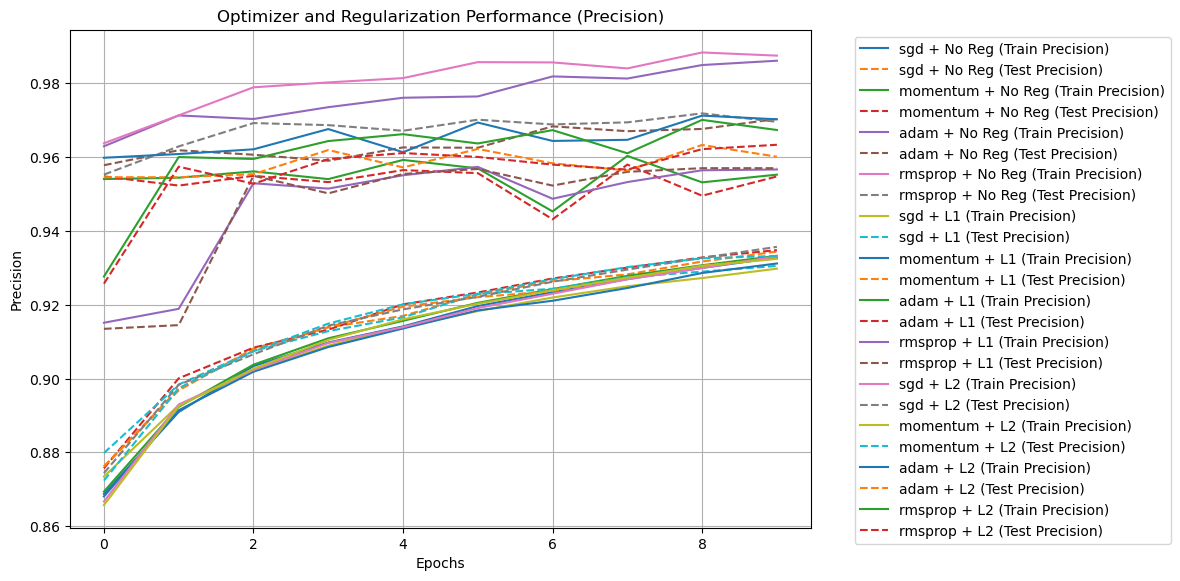

In [280]:
# Precision Grafiği
plt.figure(figsize=(12, 6))
for reg in regularizations:
    for opt in optimizers:
        plt.plot(results[reg][opt]['train_precision'], label=f"{opt} + {reg or 'No Reg'} (Train Precision)")
        plt.plot(results[reg][opt]['test_precision'], linestyle='--', label=f"{opt} + {reg or 'No Reg'} (Test Precision)")

plt.title("Optimizer and Regularization Performance (Precision)")
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()


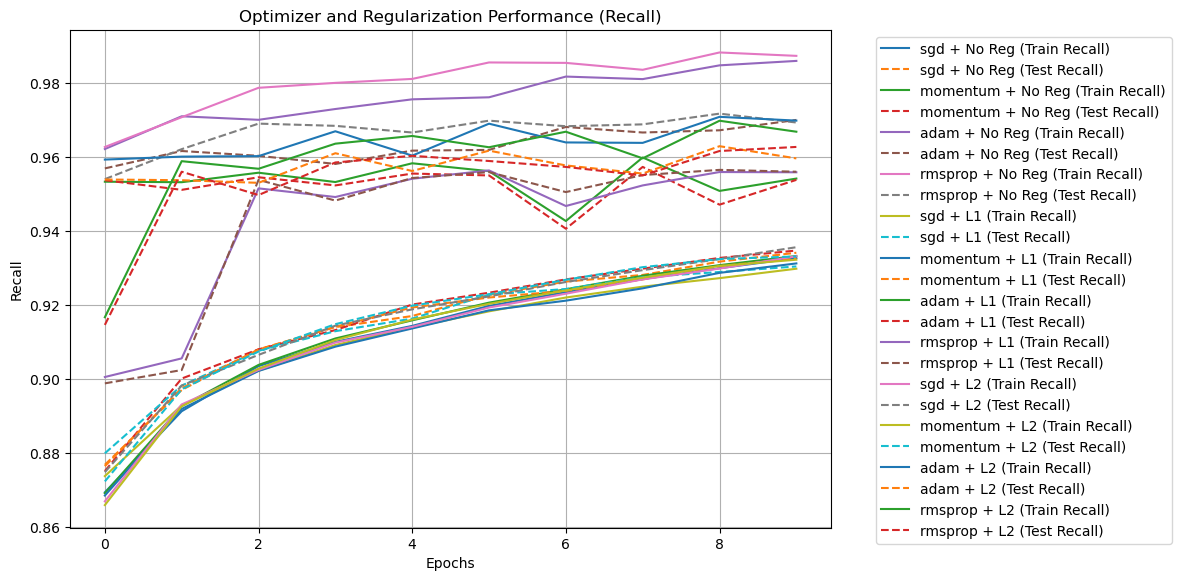

In [281]:
# Recall Grafiği
plt.figure(figsize=(12, 6))
for reg in regularizations:
    for opt in optimizers:
        plt.plot(results[reg][opt]['train_recall'], label=f"{opt} + {reg or 'No Reg'} (Train Recall)")
        plt.plot(results[reg][opt]['test_recall'], linestyle='--', label=f"{opt} + {reg or 'No Reg'} (Test Recall)")

plt.title("Optimizer and Regularization Performance (Recall)")
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()



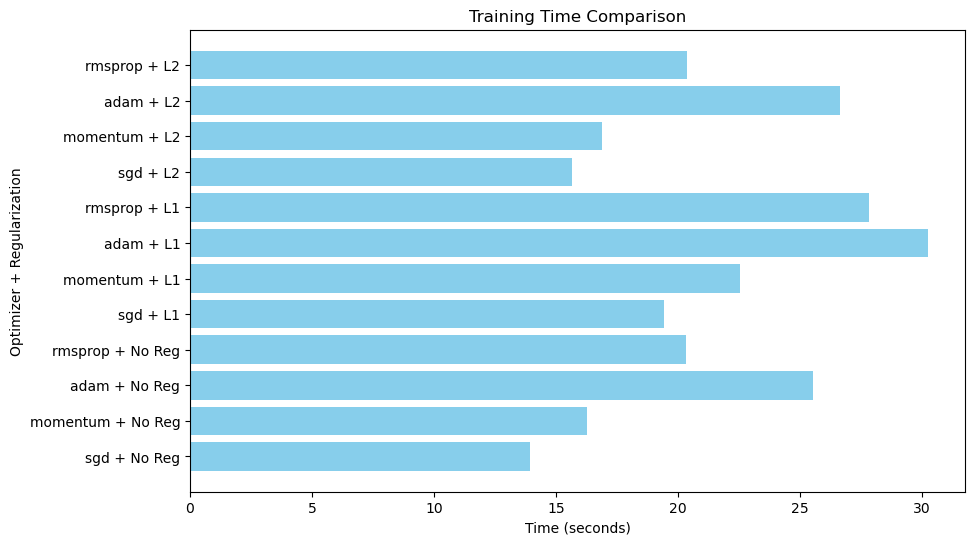

In [282]:
# Training Time Grafiği
plt.figure(figsize=(10, 6))
time_labels = []
time_values = []
for reg in regularizations:
    for opt in optimizers:
        time_labels.append(f"{opt} + {reg or 'No Reg'}")
        time_values.append(results[reg][opt]['time'])

plt.barh(time_labels, time_values, color='skyblue')
plt.title("Training Time Comparison")
plt.xlabel("Time (seconds)")
plt.ylabel("Optimizer + Regularization")
plt.show()


**Kod kaynak:** https://github.com/lionelmessi6410/Neural-Networks-from-Scratch/blob/main/NN-from-Scratch.ipynb